# 3 Langgraph API

Graph API 是 LangGraph 构建工作流 / 智能体的「底层骨架」，所有复杂流程（如并行任务、循环优化）都基于它的核心概念实现。本教学按「基础概念→核心组件→实战用法→高级特性」的顺序，用「概念 + 代码 + 解析」的方式，帮你完全掌握 Graph API。

## 第零步：配置LangSmith（可选但强烈推荐）

LangSmith 是 LangChain 官方的调试工具，可追踪 Graph 执行轨迹、查看状态变化、定位问题。

**操作步骤**：

1. 访问 LangSmith 官网 注册账号；

2. 获取 API 密钥（在账号设置中找到「API Keys」）；

3. 在代码中设置环境变量（或通过终端 export）：

In [31]:
import os
import getpass
from dotenv import load_dotenv

load_dotenv()

if not os.environ.get("LANGCHAIN_API_KEY"):
    os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("请输入LangSmith API密钥：")
os.environ["LANGCHAIN_TRACING_V2"] = "true"  # 开启追踪
os.environ["LANGCHAIN_PROJECT"] = "LangGraph-Use-Graph-API"  # 项目名（自定义）

## 第一步：先搞懂 Graph API 的核心三要素

LangGraph 本质是用「图（Graph）」模型描述工作流，而图的构成依赖三个不可缺少的要素：**State（状态）**、**Nodes（节点）**、**Edges（边）**。这是理解所有后续内容的基础。

|**要素**|	**核心作用**|	**类比（生活化理解）**|
|--|--|--|
|**State**|	共享数据结构，存储工作流的「当前快照」|	厨房的「食材台」（所有步骤都用这里的食材）|
|**Nodes**|	执行逻辑的函数（计算 / 调用工具 / LLM）|	厨房的「厨师」（负责处理食材，产出半成品）|
|**Edges**|	控制流程的规则，决定「下一个执行哪个节点」|	厨房的「流程单」（告诉厨师做完后交给谁）|


## 第二步：核心图类「StateGraph」与编译流程

LangGraph 中最常用的图是 StateGraph（专为有状态工作流设计），使用它必须经过「定义→添加节点 / 边→编译」三个步骤，**编译是必做步骤**（否则图无法执行）。

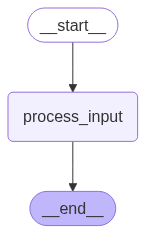

处理后：Hello Graph API


In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image

# 1. 定义State：存储输入和结果
class MyState(TypedDict):
    user_input: str
    result: str

# 2. 初始化 StateGraph
graph = StateGraph(MyState)

# 3. 定义节点
def process_input(state: MyState):
    return {"result": f"处理后：{state['user_input']}"}

# 4. 添加节点
graph.add_node("process_input", process_input)

graph.add_edge(START, "process_input")
graph.add_edge("process_input", END)

agent = graph.compile()
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))
out_put = agent.invoke({"user_input": "Hello Graph API"})
print(out_put["result"])

**编译的作用**

- **结构校验**：检查是否有 “孤儿节点”（没有边连接的节点）、是否遗漏 START/END 等。

- **绑定运行时**：配置缓存、断点、递归限制等运行参数（后续会讲）。

- **生成执行逻辑**：将节点和边的定义转化为可执行的流程，支持并行、循环等复杂逻辑。

## 第三步：深入理解「State（状态）」—— 工作流的 “共享内存”

State 是 Graph API 的核心，所有节点的交互都通过 State 完成。需要重点掌握「State Schema（状态结构）」和「Reducers（状态更新规则）」两个关键点。

### 3.1 State Schema：定义状态的 “数据结构”

Schema 规定了 State 包含哪些字段（如 user_input、result），支持三种定义方式，各有适用场景：

|**定义方式**|	**优点**|	**适用场景**|	**代码示例**|
|--|--|--|--|
|**TypedDict**|	性能最优，简洁|	无需数据验证，追求效率|	`class MyState(TypedDict): foo: int`|
|**dataclass**|	支持默认值，可读性好|	需要给字段设默认值|	`@dataclass class MyState: foo: int = 0`|
|**Pydantic Model**|	支持数据验证（类型 / 范围）|	需要确保输入合法性（如数值范围）|	`class MyState(BaseModel): foo: int = Field(ge=0)`|


**进阶：多 Schema 设计（输入 / 输出 / 内部状态分离）**

实际场景中，常需要区分「用户输入字段」「工作流输出字段」「内部临时字段」，这时可以用「多 Schema 组合」：

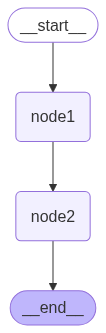

{'final_result': '最终：临时处理：测试多Schema'}


In [35]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image

# 1. 定义输入Schema（用户只需传这些字段）
class InputSchema(TypedDict):
    user_input: str

# 2. 定义输出Schema（用户最终能拿到这些字段）
class OutputSchema(TypedDict):
    final_result: str

# 3. 定义内部Schema（工作流内部使用的所有字段）
class InternalSchema(TypedDict):
    user_input: str
    temp_data: str
    final_result: str

# 4. 初始化StateGraph
graph = StateGraph(
    InternalSchema,
    input_schema=InputSchema,   # 限制输入字段
    output_schema=OutputSchema, # 限制输出字段
)

# 5. 定义节点
def node1(state: InputSchema) -> InternalSchema:
    # 输入：读取 InputSchema 的 user_input
    # 输出：更新 InternalSchema 的 temp_data
    return {"temp_data": f"临时处理：{state['user_input']}"}

def node2(state: InternalSchema) -> OutputSchema:
    # 输入：读取 InternalSchema 的 temp_data
    # 输出：更新 OutputSchema 的 final_result
    return {"final_result": f"最终：{state['temp_data']}"}

# 6. 添加节点和边
graph.add_sequence([node1, node2]) # 顺序序列的简写
graph.add_edge(START, "node1")
graph.add_edge("node2", END)

# 7. 编译并执行
agent = graph.compile()
display(Image(agent.get_graph().draw_mermaid_png()))
output = agent.invoke({"user_input": "测试多Schema"})
print(output)

### 3.2 Reducers: 定义状态的“更新规则”

每个 State 字段都有自己的更新规则（Reducer），默认规则是「覆盖」（新值替换旧值）。但实际场景中需要「合并」（如累加列表、追加消息），这时需要显式指定 Reducer。

**常用 Reducer 类型**

1. **默认 Reducer（覆盖）**：无需显式指定，新值直接替换旧值。

In [ ]:
class MyState(TypedDict):
    foo: int # 默认覆盖

# 场景： 初始 foo=1，节点返回{"foo":2} -> 最终 foo=2

2. **operator.add(列表/数值合并)**：用`Annotated`标注，实现列表追加、数值累加。

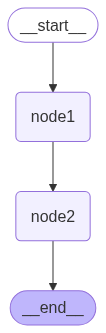

{'foo': 2, 'bar': ['init', 'a', 'b']}


In [6]:
from typing import Annotated
from operator import add
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image

class MyState(TypedDict):
    foo: int # 默认覆盖
    bar: Annotated[list[str], add] # 列表合并

# 初始化图
graph = StateGraph(MyState)

# 节点1：更新foo和bar
def node1(state: MyState):
    return {"foo": 2, "bar": ["a"]}

# 节点2：持续更新bar
def node2(state: MyState):
    return {"bar": ["b"]}

# 添加节点和边
graph.add_node("node1", node1)
graph.add_node("node2", node2)

graph.add_edge(START, "node1")
graph.add_edge("node1", "node2")
graph.add_edge("node2", END)

chain = graph.compile()
display(Image(chain.get_graph().draw_mermaid_png()))
output = chain.invoke({"foo":1, "bar": ["init"]})
print(output)


3. **add_messages(消息列表专用)**：处理LLM对话消息（如`HumanMessage`、`AIMessage`），支持 **追加新消息** 和 **更新旧消息** （如人工修改历史消息）。

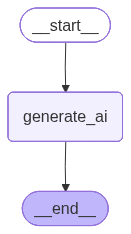

human: 你好
ai: AI 回复：你好


In [7]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages # 消息专用 Reducer
from IPython.display import Image

# 定义含消息的State
class MessageState(TypedDict):
    messages: Annotated[list[HumanMessage | AIMessage], add_messages]

# 初始化图
graph = StateGraph(MessageState)

def generate_ai(state: MessageState):
    user_msg = state["messages"][-1].content # 读取最后一条用户消息
    ai_msg = AIMessage(content=f"AI 回复：{user_msg}")
    return {"messages": [ai_msg]} # add_messages 会自动追加

graph.add_node("generate_ai", generate_ai)

graph.add_edge(START, "generate_ai")
graph.add_edge("generate_ai", END)

chain = graph.compile()
display(Image(chain.get_graph().draw_mermaid_png()))

output = chain.invoke({
    "messages": [HumanMessage(content="你好")]
})

for msg in output["messages"]:
    print(f"{msg.type}: {msg.content}")


**简化：预定义状态「MessagesState」**

由于"**消息列表**"是最常用的场景，LangGraph提供了预定义的`MessagesState`，以及包含了`messages`字段和`add_messages` Reducer，直接继承即可拓展：

In [ ]:
from langgraph.graph import MessagesState

class MyState(MessagesState):
    documents: list[str] # 新增字段，默认覆盖规则

### 3.3 Pydantic 状态基础

若需「运行时数据验证」（如确保字段类型正确、数值在范围内），可使用 Pydantic 模型替代 TypedDict。但需注意 Pydantic 的局限性（文档中已说明）。

In [37]:
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END

# 1. 用Pydantic定义状态
class PydanticState(BaseModel):
    name: str = Field(description="用户名，必须是字符串")
    age: int = Field(ge=0, le=150, description="年龄，0-150之间的整数")

# 2. 定义节点
def validate_node(state: PydanticState):
    return {"name": f"Hello {state.name}!", "age": state.age + 1}

# 3. 构建 graph
graph = StateGraph(PydanticState)
graph.add_sequence([validate_node])
graph.add_edge(START, "validate_node")
graph.add_edge("validate_node", END)

chain = graph.compile()

# 测试1：传入合法数据
valid_input = {"name": "Alice", "age": 25}
result_valid = chain.invoke(valid_input)
print("合法输入结果：", result_valid)

# 测试2：传入非法数据
try:
    invalid_input = {"name": "Bob", "age": 200}
    chain.invoke(invalid_input)
except Exception as e:
    print(e)


合法输入结果： {'name': 'Hello Alice!', 'age': 26}
1 validation error for PydanticState
age
  Input should be less than or equal to 150 [type=less_than_equal, input_value=200, input_type=int]
    For further information visit https://errors.pydantic.dev/2.11/v/less_than_equal


## 第四步：掌握「Nodes（节点）」—— 工作流的 “执行单元”

节点是执行具体逻辑的函数（如调用 LLM、工具、数据处理），支持同步 / 异步函数，还可接收「配置」和「运行时上下文」。

### 4.1 节点的三种常见类型

根据需要接收的参数，节点分为以下三类：

|**节点类型**|	**接收参数**|	**适用场景**|	**代码示例**|
|--|--|--|--|
|**基础节点**|	仅 state|	简单逻辑（如数据处理）|	`def node(state: MyState): ...`|
|**带配置节点**|	state + config|	需要线程 ID、追踪标签等配置|	`def node(state: MyState, config: RunnableConfig): ...`|
|**带运行时节点**|	state + runtime|	需要上下文（如数据库连接、LLM 提供商）|	`def node(state: MyState, runtime: Runtime[Context]): ...`|

**实战：带配置与运行时的节点**

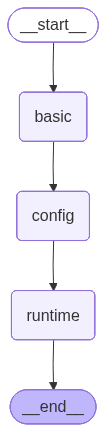

用户user_001用openai处理：测试节点


In [12]:
from dataclasses import dataclass
from typing_extensions import TypedDict
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END
from langgraph.runtime import Runtime
from IPython.display import Image

# 1. 定义State
class MyState(TypedDict):
    user_input: str
    result: str

# 2. 定义运行时上下文（如LLM提供商， 用户ID）
@dataclass
class MyContext:
    llm_provider: str
    user_id: str

# 3. 定义3种节点
# 基础节点：仅处理state
def basic_node(state: MyState):
    return {"result": f"基础处理：{state['user_input']}"}

# 带配置的节点：获取thread_id（用于多线程追踪）
def config_node(state: MyState, config: RunnableConfig):
    thread_id = config["configurable"]["thread_id"] # 从配置中拿到 thread_id
    return {"result": f"Thread ID: {thread_id} | 处理：{state['user_input']}"}

def runtime_node(state: MyState, runtime: Runtime[MyContext]):
    llm_prov = runtime.context.llm_provider # 从运行时拿上下文
    user_id = runtime.context.user_id
    return {"result": f"用户{user_id}用{llm_prov}处理：{state['user_input']}"}


# 4. 初始化图
graph = StateGraph(MyState, context_schema=MyContext)

# 5. 添加节点
graph.add_node("basic", basic_node)
graph.add_node("config", config_node)
graph.add_node("runtime", runtime_node)

graph.add_edge(START, "basic")
graph.add_edge("basic", "config")
graph.add_edge("config", "runtime")
graph.add_edge("runtime", END)

chain = graph.compile()
display(Image(chain.get_graph().draw_mermaid_png()))

output = chain.invoke(
    {"user_input": "测试节点"},
    config={
        "configurable": {"thread_id": "thread_001"}, # 给config节点传入 thread_id
        "recursion_limit": 10, # 递归限制(后面讲)
    },
    context=MyContext(llm_provider="openai", user_id="user_001") # 运行时上下文
)

print(output["result"])


In [38]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.runtime import Runtime  # 用于访问运行时上下文

# 1. 定义运行时配置Schema（传递的参数结构）
class ContextSchema(TypedDict):
    runtime_param: str  # 运行时参数（如LLM提供商、系统提示词）

# 2. 定义Graph状态（仅包含业务数据，不包含配置）
class BusinessState(TypedDict):
    result: str

# 3. 定义节点（接收状态+运行时上下文）
def runtime_node(state: BusinessState, runtime: Runtime[ContextSchema]):
    # 从runtime.context中获取运行时参数
    param = runtime.context["runtime_param"]
    # 根据参数生成结果
    return {"result": f"业务结果（基于运行时参数：{param}）"}

# 4. 构建Graph（指定context_schema）
graph_builder = StateGraph(
    BusinessState,
    context_schema=ContextSchema  # 绑定运行时配置Schema
)
graph_builder.add_node("runtime_node", runtime_node)
graph_builder.add_edge(START, "runtime_node")
graph_builder.add_edge("runtime_node", END)
graph = graph_builder.compile()

# 5. 执行Graph（传入业务状态+运行时配置）
result1 = graph.invoke(
    {"result": ""},  # 业务初始状态
    context={"runtime_param": "参数A"}  # 运行时参数A
)
result2 = graph.invoke(
    {"result": ""},
    context={"runtime_param": "参数B"}  # 运行时参数B
)

print("运行时参数A结果：", result1["result"])  # 输出：业务结果（基于运行时参数：参数A）
print("运行时参数B结果：", result2["result"])  # 输出：业务结果（基于运行时参数：参数B）

运行时参数A结果： 业务结果（基于运行时参数：参数A）
运行时参数B结果： 业务结果（基于运行时参数：参数B）


In [ ]:
from dataclasses import dataclass
from langchain.chat_models import init_chat_model
from langgraph.graph import MessagesState  # 预定义消息状态

# 1. 用dataclass定义运行时配置（支持默认值）
@dataclass
class LLMContext:
    model_provider: str = "anthropic"  # 默认LLM提供商
    system_message: str | None = None  # 可选系统提示词

# 2. 定义LLM映射（根据提供商选择模型）
LLM_MAP = {
    "anthropic": init_chat_model("anthropic:claude-3-5-haiku-latest"),
    "openai": init_chat_model("openai:gpt-4o-mini")
}

# 3. 定义节点（根据运行时配置选择LLM）
def llm_node(state: MessagesState, runtime: Runtime[LLMContext]):
    # 1. 获取运行时配置
    ctx = runtime.context
    llm = LLM_MAP[ctx.model_provider]  # 选择LLM
    # 2. 拼接系统提示词（若有）
    messages = state["messages"]
    if ctx.system_message:
        from langchain_core.messages import SystemMessage
        messages = [SystemMessage(content=ctx.system_message)] + messages
    # 3. 调用LLM并返回结果
    response = llm.invoke(messages)
    return {"messages": [response]}

# 4. 构建Graph
graph_builder = StateGraph(MessagesState, context_schema=LLMContext)
graph_builder.add_node("llm_node", llm_node)
graph_builder.add_edge(START, "llm_node")
graph_builder.add_edge("llm_node", END)
graph = graph_builder.compile()

# 5. 测试1：使用默认Anthropic模型，无系统提示词
result_anthropic = graph.invoke(
    {"messages": [{"role": "user", "content": "Hi!"}]},
    context=LLMContext()  # 使用默认配置
)
print("Anthropic模型结果：")
result_anthropic["messages"][-1].pretty_print()

# 6. 测试2：使用OpenAI模型，系统提示词为"用中文回复"
result_openai = graph.invoke(
    {"messages": [{"role": "user", "content": "Hi!"}]},
    context=LLMContext(
        model_provider="openai",
        system_message="用中文回复用户"
    )
)
print("\nOpenAI模型（中文）结果：")
result_openai["messages"][-1].pretty_print()

### 4.2 特殊节点：START 与 END

- **START**：虚拟起始节点，代表 “用户输入进入图的入口”，所有流程都从 START 开始。

- **END**：虚拟终止节点，代表 “流程结束”，所有不需要继续执行的节点都连接到 END。

### 4.3 节点缓存：避免重复计算

对于耗时节点（如复杂 LLM 调用、大数据处理），可开启缓存，相同输入直接返回结果，提升效率。需配置「缓存实例」和「缓存策略（CachePolicy）」。

In [17]:
import time
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.cache.memory import InMemoryCache # 内存缓存
from langgraph.types import CachePolicy

# 1. 定义State
class MyState(TypedDict):
    x: int
    result: int

# 2. 耗时节点
def expensive_node(state: MyState) -> dict:
    time.sleep(2)   # 模拟耗时操作
    return {"result": state["x"] * 2}

# 3. 初始化图
graph = StateGraph(MyState)

# 4. 添加节点并配置缓存
graph.add_node(
    "expensive",
    expensive_node,
    cache_policy=CachePolicy(ttl=3), # 缓存策略：3秒内相同输入复用结果
)

# 5. 设置入口和出口 （直接从 expensive 节点开始和结束）
graph.set_entry_point("expensive")
graph.set_finish_point("expensive")

# 6. 编译与运行
cache = InMemoryCache()
chain = graph.compile(cache=cache)

print("第一次运行")
start = time.time()
output1 = chain.invoke({"x": 5}, stream_mode="updates")
print(f"结果：{output1}， 耗时：{time.time()-start:.2f}秒")

print("\n第二次运行(缓存内)：")
start = time.time()
output2 = chain.invoke({"x": 5}, stream_mode="updates")
print(f"结果：{output2}, 耗时：{time.time()-start:.2f}秒")

print("\n第三次运行（缓存过期）：")
time.sleep(3) #等待缓存过期
start = time.time()
output3 = chain.invoke({"x": 5}, stream_mode="updates")
print(f"结果：{output3}, 耗时：{time.time()-start:.2f}秒")

第一次运行
结果：[{'expensive': {'result': 10}}]， 耗时：2.00秒

第二次运行(缓存内)：
结果：[{'expensive': {'result': 10}, '__metadata__': {'cached': True}}], 耗时：0.00秒

第三次运行（缓存过期）：
结果：[{'expensive': {'result': 10}}], 耗时：2.00秒


### 4.4 重试策略（Retry Policy）

为节点配置重试规则，仅在特定异常（如数据库连接错误、API 5xx 错误）时重试。

In [ ]:
from langgraph.types import RetryPolicy
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

# 1. 定义状态
class RetryState(TypedDict):
    data: str

# 2. 定义易失败节点（模拟API调用超时）
import time
import random

def flaky_node(state: RetryState):
    # 模拟50%概率失败（抛异常）
    if random.random() < 0.5:
        raise Exception("模拟API超时错误（需要重试）")
    time.sleep(1)  # 模拟耗时操作
    return {"data": f"处理完成：{state['data']}"}

# 3. 构建Graph（为节点配置重试策略）
graph_builder = StateGraph(RetryState)
# 添加节点：重试策略（默认重试3次，仅重试特定异常）
graph_builder.add_node(
    "flaky_node",
    flaky_node,
    retry_policy=RetryPolicy(
        max_attempts=3,  # 最大重试3次
        # retry_on：自定义重试条件（默认重试网络错误、API 5xx等，此处用默认）
    )
)
graph_builder.add_edge(START, "flaky_node")
graph_builder.add_edge("flaky_node", END)
graph = graph_builder.compile()

# 4. 执行（若失败会自动重试，直到成功或达到最大次数）
start_time = time.time()
try:
    result = graph.invoke({"data": "测试重试"})
    print(f"执行成功！结果：{result['data']}，耗时：{time.time()-start_time:.2f}秒")
except Exception as e:
    print(f"重试3次后仍失败：{e}")

In [ ]:
import sqlite3  # 模拟数据库操作

def db_node(state: RetryState):
    # 模拟数据库操作（可能抛OperationalError）
    conn = sqlite3.connect(":memory:")
    cursor = conn.cursor()
    try:
        cursor.execute("SELECT * FROM non_existent_table;")  # 故意查不存在的表
    except sqlite3.OperationalError as e:
        raise e  # 抛出数据库操作错误
    finally:
        conn.close()
    return {"data": "数据库查询完成"}

# 构建Graph：仅重试sqlite3.OperationalError
graph_builder = StateGraph(RetryState)
graph_builder.add_node(
    "db_node",
    db_node,
    retry_policy=RetryPolicy(
        max_attempts=2,
        retry_on=sqlite3.OperationalError  # 仅重试数据库操作错误
    )
)
graph_builder.add_edge(START, "db_node")
graph = graph_builder.compile()

# 执行：会重试2次（均失败，因为表不存在）
try:
    graph.invoke({"data": "测试数据库重试"})
except sqlite3.OperationalError as e:
    print("数据库重试后失败：", e)

## 第五步：掌握「Edges（边）」—— 工作流的 “交通规则”

边控制流程的走向，分为「普通边」「条件边」「入口边」，还支持动态节点（Send）和状态更新 + 路由（Command）。

### 5.1 普通边：固定流程

从一个节点固定跳转到另一个节点，适用于 “无需判断的线性流程”。

In [ ]:
# 普通边：node_a 执行完毕后，固定执行 node_b
graph.add_edge("node_a", "node_b")

### 5.2 条件边：动态路由

根据 State 的数据决定跳转到哪个节点，适用于 “需要分支的流程”（如 “评估笑话是否有趣，有趣则结束，无趣则优化”）。

In [22]:
from typing_extensions import TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from langgraph.runtime import Runtime
from dataclasses import dataclass

class JokeState(TypedDict):
    joke: str
    is_funny: bool

@dataclass
class MyContext:
    llm_provider: str

def generate_joke(state: JokeState, runtime: Runtime[MyContext]):
    llm_prov = runtime.context.llm_provider # 从运行时拿上下文
    print("LLM 提供商：", llm_prov)
    return {"joke": "猫为什么喜欢玩电脑？因为有鼠标！", "is_funny": False}

def improve_joke(state: JokeState):
    return {"joke": "猫为什么喜欢玩电脑？因为有“鼠标”可以抓！", "is_funny": True}

def route_joke(state: JokeState) -> Literal["improve_joke", END]:
    if state["is_funny"]:
        return END
    else:
        return "improve_joke"

graph = StateGraph(JokeState, context_schema=MyContext)
graph.add_node("generate", generate_joke)
graph.add_node("improve", improve_joke)

# 添加边
graph.add_edge(START, "generate")
graph.add_conditional_edges(
    "generate",
    route_joke,
    {
        "improve_joke": "improve",
        END: END,
    }
)
graph.add_edge("improve", END)

chain = graph.compile()
output = chain.invoke({"joke": "", "is_funny": False}, context=MyContext(llm_provider="openai"))
print(output["joke"])


LLM 提供商： openai
猫为什么喜欢玩电脑？因为有“鼠标”可以抓！


### 5.3 动态节点：Send API

当 “节点数量不确定” 时（如 “根据用户输入的主题列表，生成多个笑话，每个主题一个节点”），用 Send 动态创建节点，实现 “map-reduce” 模式。

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send  # 动态节点API
import operator
from typing import Annotated

# 1. 定义状态：topics是待处理的主题列表，results是合并结果
class MapReduceState(TypedDict):
    topics: list[str]  # 输入：主题列表（数量不确定）
    results: Annotated[list[str], operator.add]  # 输出：合并的结果

# 2. 定义节点
def map_node(state: MapReduceState):
    """Map阶段：拆分主题，动态创建子节点（每个主题一个generate_node）"""
    # 对每个主题，生成Send对象：指定目标节点+传递给子节点的数据
    return [Send("generate_node", {"topic": topic}) for topic in state["topics"]]

def generate_node(state: dict) -> dict:
    """Reduce阶段的子节点：处理单个主题（输入是Send传递的{"topic": ...}）"""
    topic = state["topic"]
    # 模拟生成内容（实际场景可调用LLM）
    content = f"关于「{topic}」的内容：这是动态生成的内容～"
    return {"results": [content]}  # 结果会被operator.add合并

def reduce_node(state: MapReduceState) -> dict:
    """Reduce阶段：合并所有子节点的结果"""
    combined = "\n\n".join(state["results"])
    return {"results": [f"【最终合并结果】\n{combined}"]}

# 3. 构建Map-Reduce Graph
graph_builder = StateGraph(MapReduceState)
graph_builder.add_node("map_node", map_node)
graph_builder.add_node("generate_node", generate_node)
graph_builder.add_node("reduce_node", reduce_node)

# 边配置：START→map_node→动态generate_node→reduce_node→END
graph_builder.add_edge(START, "map_node")
# 条件边：map_node返回Send对象，动态触发generate_node
graph_builder.add_conditional_edges("map_node", map_node, ["generate_node"])
# 所有generate_node执行完后，进入reduce_node
graph_builder.add_edge("generate_node", "reduce_node")
graph_builder.add_edge("reduce_node", END)
graph = graph_builder.compile()

# 4. 执行（输入3个主题，动态生成3个generate_node）
result = graph.invoke({
    "topics": ["猫", "狗", "鸟"],  # 不确定数量的主题
    "results": []
})

# 查看结果
print("Map-Reduce最终结果：")
print(result["results"][0])

### 5.4 状态更新 + 路由：Command

当需要 “同时更新 State 和决定路由” 时（如 “多智能体交接：更新当前智能体 ID，同时跳转到新智能体节点”），用 `Command` 替代条件边。

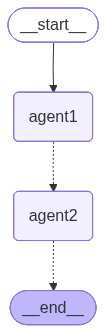

{'current_agent': 'agent2', 'task': '处理用户咨询', 'result': 'agent1 处理任务：处理用户咨询（部分完成） -> agent2 完成任务！'}


In [29]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from IPython.display import Image

class AgentState(TypedDict):
    current_agent: str
    task: str
    result: str

# 定义节点
def agent1(state: AgentState) -> Command[Literal["agent2"]]:
    #  1. 更新State：标记当前智能体为 agent1， 生成部分结果
    update = {
        "current_agent": "agent1",
        "result": f"agent1 处理任务：{state['task']}（部分完成）"
    }
    # 2. 路由：交接给agent2
    return Command(update=update, goto="agent2")

def agent2(state: AgentState) -> Command[Literal[END]]:
    # 1. 更新state：标记当前智能体为 agent2， 完成结果
    update = {
        "current_agent": "agent2",
        "result": f"{state['result']} -> agent2 完成任务！"
    }
    # 2. 路由：结束流程
    return Command(update=update, goto=END)

graph = StateGraph(AgentState)

graph.add_node("agent1", agent1)
graph.add_node("agent2", agent2)

# 连接边：内部用Command直接跳转到agent2，agent2直接跳转到END
graph.add_edge(START, "agent1")

agent = graph.compile()
display(Image(agent.get_graph().draw_mermaid_png()))
output = agent.invoke({
    "current_agent": "",
    "task": "处理用户咨询",
    "result": ""
})

print(output)

**Command vs 条件边：怎么选？**

|**场景**|	**推荐方案**|	**原因**|
|--|--|--|
|**仅需要路由，无需更新 State**|	条件边|	逻辑更简单，无需额外定义 Command|
|**需要同时更新 State 和路由**|	Command|	一步完成，避免拆分多个节点|
|**多智能体交接、人工干预后恢复流程**|	Command|	支持跨子图跳转（如子图→父图，后续讲）|


## 第六步：高级特性：子图跳转、递归限制

### 6.1 子图跳转：Command.PARENT

当使用「子图」（图中嵌套图）时，可通过 `Command(graph=Command.PARENT)` 从子图节点跳转到父图节点（如 “子图处理失败，返回父图的重试节点”）。

In [ ]:
# 核心代码片段（子图节点中跳转到父图）
from langgraph.types import Command

def subgraph_node(state: State) -> Command[Literal["parent_retry_node"]]:
    return Command(
        update={"error": "子图处理失败"},
        goto="parent_retry_node",  # 父图中的节点名
        graph=Command.PARENT       # 指定跳转到父图
    )

### 6.2 递归限制：防止无限循环

默认情况下，图的最大执行步数（super-step）为 25 步，超过会抛出 GraphRecursionError，可通过 config 修改限制：

In [ ]:
# 执行图时，设置递归限制为 50 步
output = graph.invoke(
    {"input": "测试"},
    config={"recursion_limit": 50}  # 关键：修改最大步数
)

## 第七步：总结 Graph API 核心工作流

掌握 Graph API 的关键是记住「定义→组装→执行」的流程：

- **定义 State**：确定共享数据结构（Schema）和更新规则（Reducers），常用 TypedDict 或 MessagesState。

- **定义 Nodes**：编写执行逻辑的函数（基础 / 带配置 / 带运行时），耗时节点可加缓存。

- **定义 Edges**：用普通边 / 条件边 / Send/Command 控制流程，确定 START 和 END。

- **编译图**：调用 compile() 生成可执行实例，可配置缓存、断点。

- **执行图**：用 invoke() 传入初始 State，可指定 config（递归限制）和 context（运行时上下文）。

通过以上七步，你已完全掌握 Graph API 的核心概念和实战用法。后续可结合具体场景（如智能体、多步骤工作流），灵活组合 State、Nodes、Edges 实现复杂需求。